In [121]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

from termcolor import colored

# Zaladuje jeszcze moduly do wyswietlania wykresow gestosci rozkladu prawdopodobienstwa

import scipy.stats as stats
import matplotlib as mpl

# A to jest do wyswietlania ladnych podsumowan:
import arviz as az

# Teraz zaladuje wszystkie potrzebne zabawki ze "stana"
import pystan
import stan_utility

# I jeszcze takie cudo:
from DA_tools import ribbon_plot, light, light_highlight, mid, mid_highlight, dark, dark_highlight

In [122]:
# Pare ustawien dla kolorow i wykresow z wykladow:

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
blue="#0000FF"
red="#FF0000"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [123]:
# Teraz musimy wczytac dane do zadania z readme.md:

year = [1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985]
fatal_accidents = [24, 25, 31, 31, 22, 21, 26, 20, 16, 22]
deaths = [734, 516, 754, 877, 814, 362, 764, 809, 223, 1066]
death_rate = [0.19, 0.12, 0.15, 0.16, 0.14, 0.06, 0.13, 0.13, 0.03, 0.15]
miles_flown = [3863.0, 4300.0, 5027.0, 5481.0, 5814.0, 6033.0, 5877.0, 6223.0, 7433.0, 7107.0]
dane = {'Year' : year, 'Fatal accidents' : fatal_accidents, 'Passenger deaths' : deaths, 'Death rate' : death_rate, 'Miles flown [100 mln miles]' : miles_flown}

# I tworzymy dataframe zeby moc latwo wyswietlac dane:
data = pd.DataFrame(dane).set_index('Year')
    

In [124]:
data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


Year
1976     734
1977     516
1978     754
1979     877
1980     814
1981     362
1982     764
1983     809
1984     223
1985    1066
Name: Passenger deaths, dtype: int64
Lambda (mean value) is: 691.9


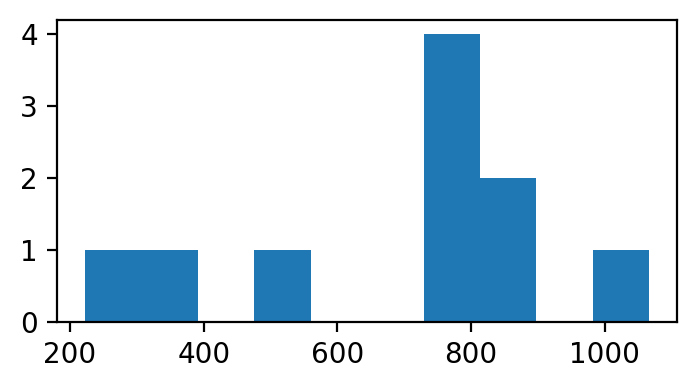

In [125]:
print(colored(data['Passenger deaths'], 'cyan'))

lambda_passenger_deaths = data['Passenger deaths'].mean()
print(colored("Lambda (mean value) is: ", 'yellow') + colored(str(lambda_passenger_deaths), 'cyan'))

plt.figure(figsize=(4,2))
plt.hist(data['Passenger deaths'])
plt.show()

In [126]:
# Szybko tworzymy model do stana:

Prior_model_stan_file = open("Prior_model.stan", "w")

# Niby nie powinno sie uzywac informacji z danych, ale po dyskusji z kolegami wiem, ze nie ma tutaj jak inaczej sie chwycic, wiec wrzucam lambde z poprzedniej komorki:
Prior_model_stan_file.write("\
generated quantities \n\
{\n\
    real lambda = normal_rng(692,200);\n\
    int deaths = poisson_rng(lambda);\n\
}\n\
")

Prior_model_stan_file.close()

# Tak jak na wykladzie, kompiluje model:
# TO MOZE POTRWAC!

model_prior = stan_utility.compile_model('Prior_model.stan')


Using cached StanModel


In [127]:
iterations = 10000
# No i tutaj robimy sobie sampling, zeby zobaczyc jakie dostaniemy wyniki
sampling_data = model_prior.sampling(data = dict(), seed = 11062020, algorithm = "Fixed_param", iter = iterations, warmup = 0)

# Wyciagamy dane z naszego samplowania:
results_prior = sampling_data.extract()
lambda_prior = results_prior['lambda']
deaths_prior = results_prior['deaths']

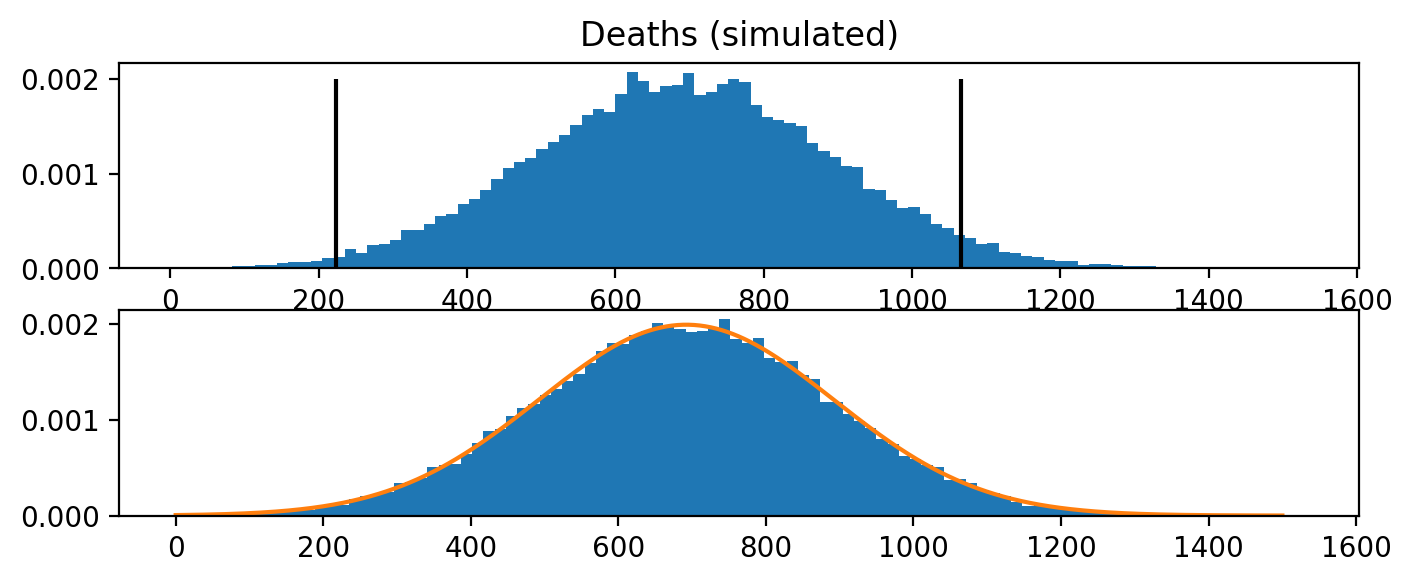

In [128]:
# Bedziemy wyswietlac wyniki:

max_deaths = data['Passenger deaths'].max()
min_deaths = data['Passenger deaths'].min()

plt.figure(figsize=(8,3))

x_axis = np.linspace(0, 1500, 1000)
y_axis = stats.norm.pdf(x_axis, loc=692, scale=200)

plt.subplot(2,1,1)
plt.hist(deaths_prior, density=True, bins=100)
plt.vlines([min_deaths, max_deaths], ymin=0, ymax=0.002)
plt.title("Deaths (simulated)") # Brzmi troche creepy :3

plt.subplot(2,1,2)
plt.hist(lambda_prior, density=True, bins=100)
plt.plot(x_axis, y_axis)


In [129]:
# Teraz sobie napisze pliczek do stana, w ktorym bedzie model:

Fit_model_stan_file = open("Fit_model.stan", "w")

Fit_model_stan_file.write("\
data \n\
{\n\
	int N;\n\
	int deaths[N];\n\
}\n\
\n\
parameters \n\
{\n\
	real<lower=0> lambda;\n\
}\n\
\n\
model \n\
{\n\
	lambda ~ normal(692,200);\n\
	deaths ~ poisson(lambda);\n\
}\n\
\n\
generated quantities\n\
{\n\
	int death = poisson_rng(lambda);\n\
}\n\
")

Fit_model_stan_file.close()

# Tak jak na wykladzie, kompiluje model:
# TO MOZE POTRWAC!

model_fit = stan_utility.compile_model('Fit_model.stan')


Using cached StanModel


In [130]:
dane = dict(N=len(data['Passenger deaths']), deaths=data['Passenger deaths'])
# No i tutaj robimy sobie sampling, zeby zobaczyc jakie dostaniemy wyniki
sampling_data = model_fit.sampling(data = dane, seed = 11062020)

# Wyciagamy dane z naszego samplowania:
results_fit = sampling_data.extract()
lambda_fit = results_fit['lambda']
deaths_fit = results_fit['death']

# Wyswietlamy podsumowanie zbiorcze naszych wynikow (ogolnie spoko bajer)
az.summary(sampling_data, var_names=['lambda'], round_to=3, kind='stats')

,mean,sd,hpd_3%,hpd_97%
lambda,692.084,8.345,675.387,706.427


Text(0.5, 1.0, 'Data obtained from model (predicted)')

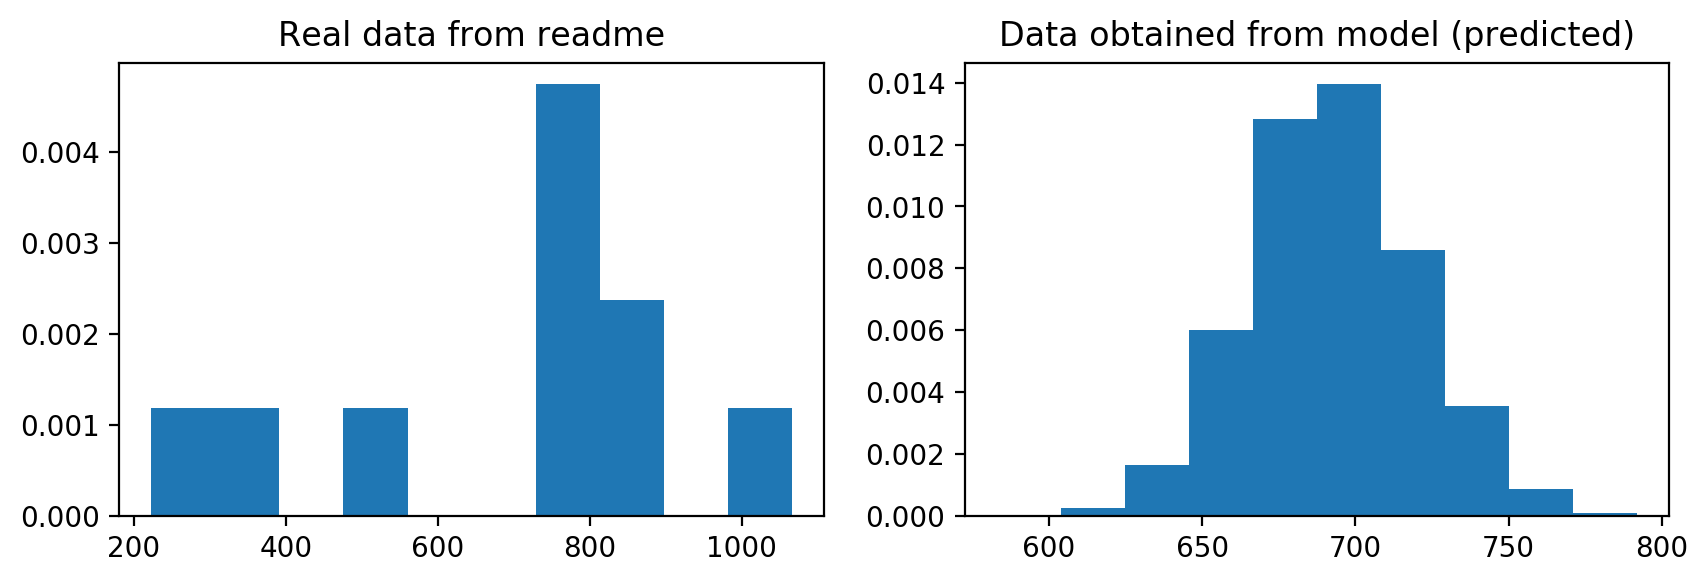

In [131]:
# Teraz histogramy z naszych danych:

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.hist(data['Passenger deaths'], density=True)
plt.title("Real data from readme")

plt.subplot(1,2,2)
plt.hist(deaths_fit, density=True)
plt.title("Data obtained from model (predicted)")


In [132]:
mean_deathRate = data['Death rate'].mean()
print("Mean value of death rate from readme: " + str(mean_deathRate))

Mean value of death rate from readme: 0.126


In [133]:
# Teraz stworzymy model nr 2, gdzie mean value bedzie stale, a inne dane sie zmieniaja (intensywnosc latania i liczba kilomentrow):

Prior_fir_model_stan_file = open("Prior_fir_model.stan", "w")

Prior_fir_model_stan_file.write("\
data \n\
{\n\
	int N;\n\
	real Miles[N];\n\
}\n\
\n\
generated quantities \n\
{\n\
	real beta = beta_rng(2,10);\n\
	int deaths[N];\n\
	for(i in 1:N) \n\
    {\n\
		deaths[i] = poisson_rng(Miles[i]*beta);\n\
	}\n\
}\n\
")

Prior_fir_model_stan_file.close()

# Tak jak na wykladzie, kompiluje model:
# TO MOZE POTRWAC!

Prior_model_fit = stan_utility.compile_model('Prior_fir_model.stan')


Using cached StanModel


In [134]:
min_flown_miles = data['Miles flown [100 mln miles]'].min()
max_flown_miles = data['Miles flown [100 mln miles]'].max()
iterations = 10000

dane = dict(N=50, Miles=np.linspace(min_flown_miles, max_flown_miles))
# No i tutaj robimy sobie sampling, zeby zobaczyc jakie dostaniemy wyniki
sampling_data = Prior_model_fit.sampling(data = dane, seed = 11062020, iter=iterations, warmup=0, chains=1, refresh=iterations, algorithm='Fixed_param')

# Wyciagamy dane z naszego samplowania:
results_prior_fit = sampling_data.extract()
beta_prior_fit = results_prior_fit['beta']
deaths_prior_fit = results_prior_fit['deaths']


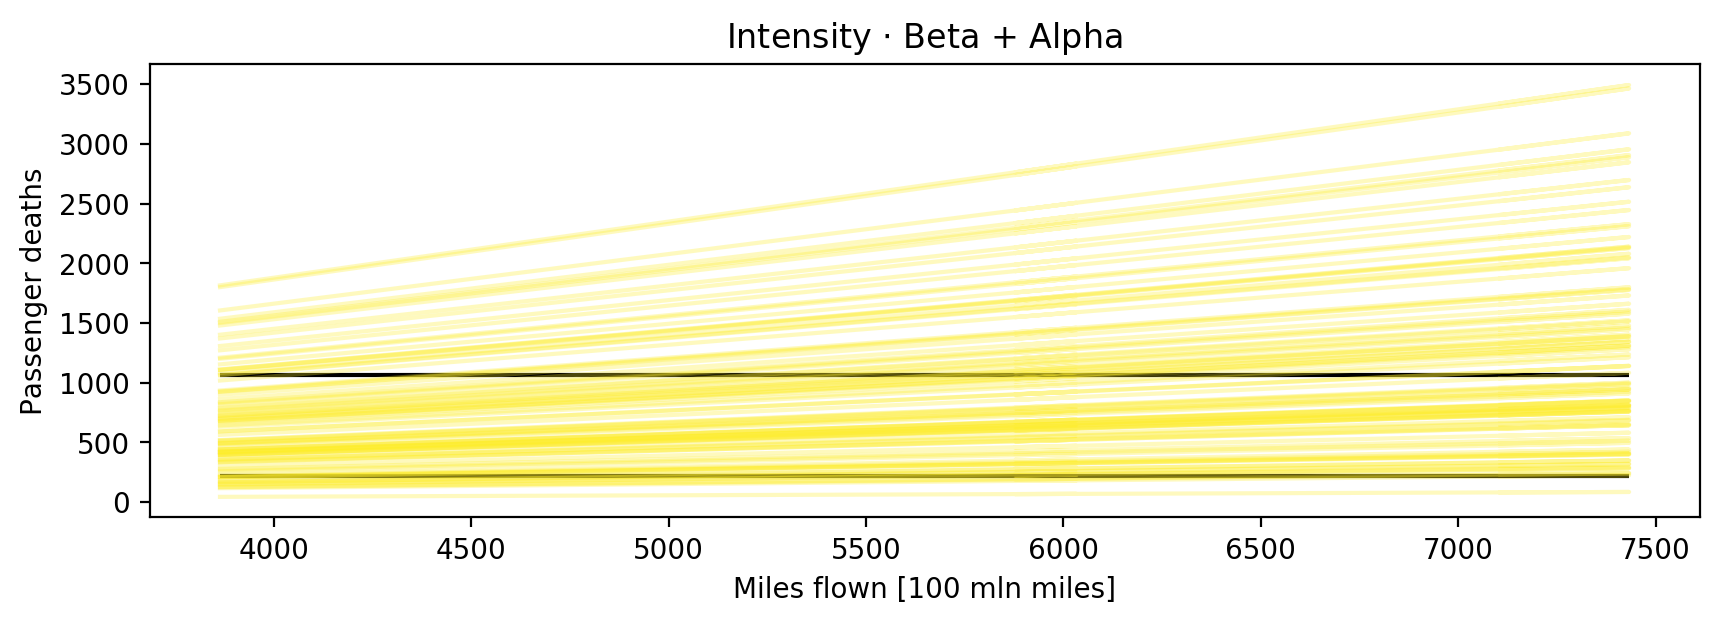

In [135]:
# Teraz wykresiki z naszych danych:

plt.figure(figsize=(10,3))

min_pass_deaths = data['Passenger deaths'].min()
max_pass_deaths = data['Passenger deaths'].max()

plt.hlines([min_pass_deaths, max_pass_deaths], xmin=min_flown_miles, xmax=max_flown_miles)

for i in range(100):
    plt.plot(data['Miles flown [100 mln miles]'], (beta_prior_fit[i]*data['Miles flown [100 mln miles]']), color=mid, alpha=0.3)
    
plt.xlabel('Miles flown [100 mln miles]')
plt.ylabel('Passenger deaths')
plt.title('Intensity $\cdot$ Beta + Alpha')
plt.show()



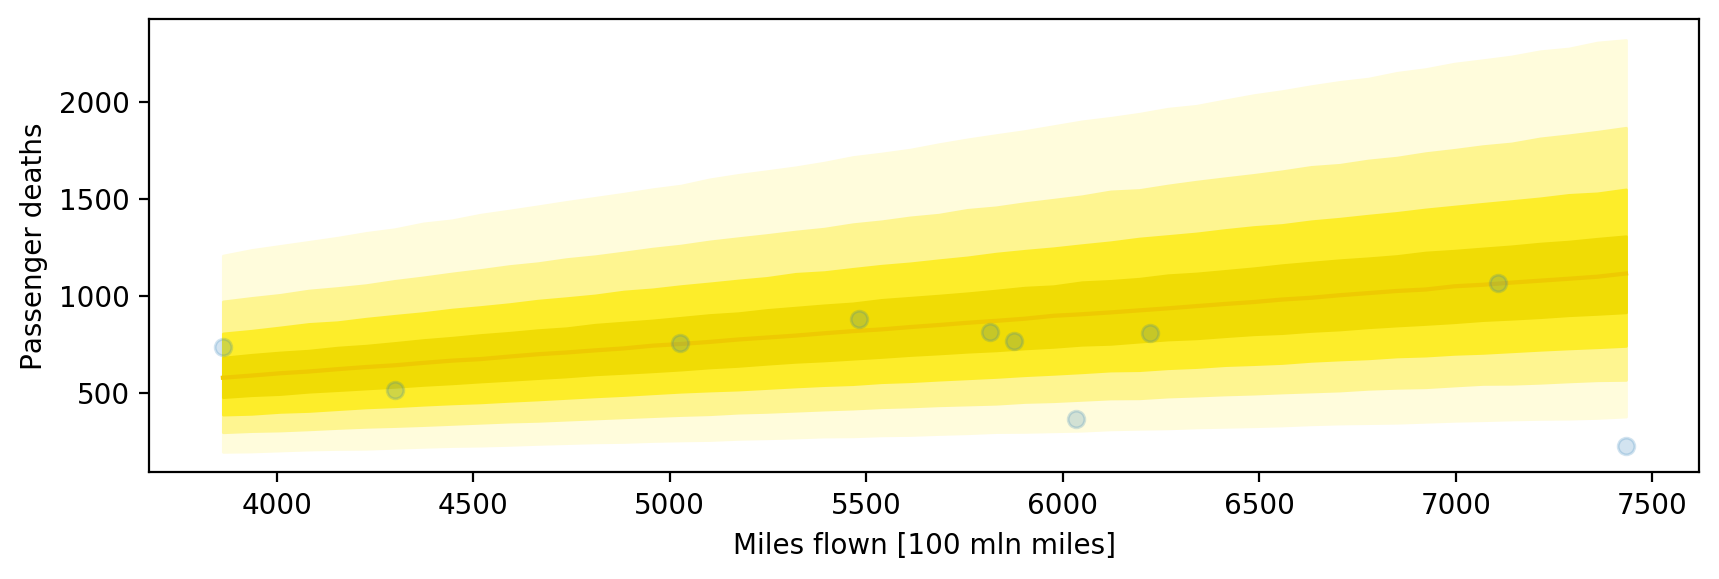

In [136]:
fig, axes = plt.subplots(1,1, figsize=(10,3))

axes = ribbon_plot(dane['Miles'], deaths_prior_fit, axes)
plt.scatter( data['Miles flown [100 mln miles]'],
             data['Passenger deaths'],
             alpha = 0.2)
plt.xlabel('Miles flown [100 mln miles]')
plt.ylabel('Passenger deaths')
plt.show()

In [137]:
# Teraz stworzymy model nr 2, gdzie mean value bedzie stale, a inne dane sie zmieniaja (intensywnosc latania i liczba kilomentrow):

Fit2_model_stan_file = open("Fit2_model.stan", "w")

Fit2_model_stan_file.write("\
data \n\
{\n\
	int N; \n\
	int deaths[N]; \n\
	vector[N] Miles;\n\
}\n\
\n\
parameters \n\
{\n\
	real beta;\n\
}\n\
\n\
transformed parameters \n\
{\n\
	vector[N] lambda = Miles * beta;\n\
}\n\
\n\
model \n\
{\n\
	beta ~ beta(2,10);\n\
	deaths ~ poisson(lambda);\n\
}\n\
\n\
generated quantities \n\
{\n\
	int death[N];\n\
	for (i in 1:N) {\n\
		death[i] = poisson_rng(lambda[i]);\n\
	}\n\
}\n\
\n\
")

Fit2_model_stan_file.close()

# Tak jak na wykladzie, kompiluje model:
# TO MOZE POTRWAC!

model_fit2 = stan_utility.compile_model('Fit2_model.stan')

Using cached StanModel


In [138]:
dane = dict(N=len(data), deaths=data['Passenger deaths'], Miles=data['Miles flown [100 mln miles]'])
# No i tutaj robimy sobie sampling, zeby zobaczyc jakie dostaniemy wyniki
sampling_data = model_fit2.sampling(data = dane, seed = 11062020)

# Wyciagamy dane z naszego samplowania:
results_model_fit2 = sampling_data.extract()
beta_model_fit2 = results_model_fit2['beta']
lambda_model_fit2 = results_model_fit2['lambda']
deaths_model_fit2 = results_model_fit2['death']

# I podsumowanko naszym ulubionym "az"
az.summary(sampling_data, var_names=['beta', 'lambda'], round_to=2, kind='stats')


,mean,sd,hpd_3%,hpd_97%
beta,0.12,0.00,0.12,0.12
lambda[0],467.61,5.65,457.16,478.54
lambda[1],520.51,6.29,508.87,532.67
lambda[2],608.52,7.35,594.91,622.73
lambda[3],663.47,8.01,648.64,678.97
lambda[4],703.78,8.50,688.04,720.22
lambda[5],730.29,8.82,713.96,747.35
lambda[6],711.41,8.59,695.50,728.03
lambda[7],753.29,9.10,736.45,770.89
lambda[8],899.76,10.86,879.64,920.78


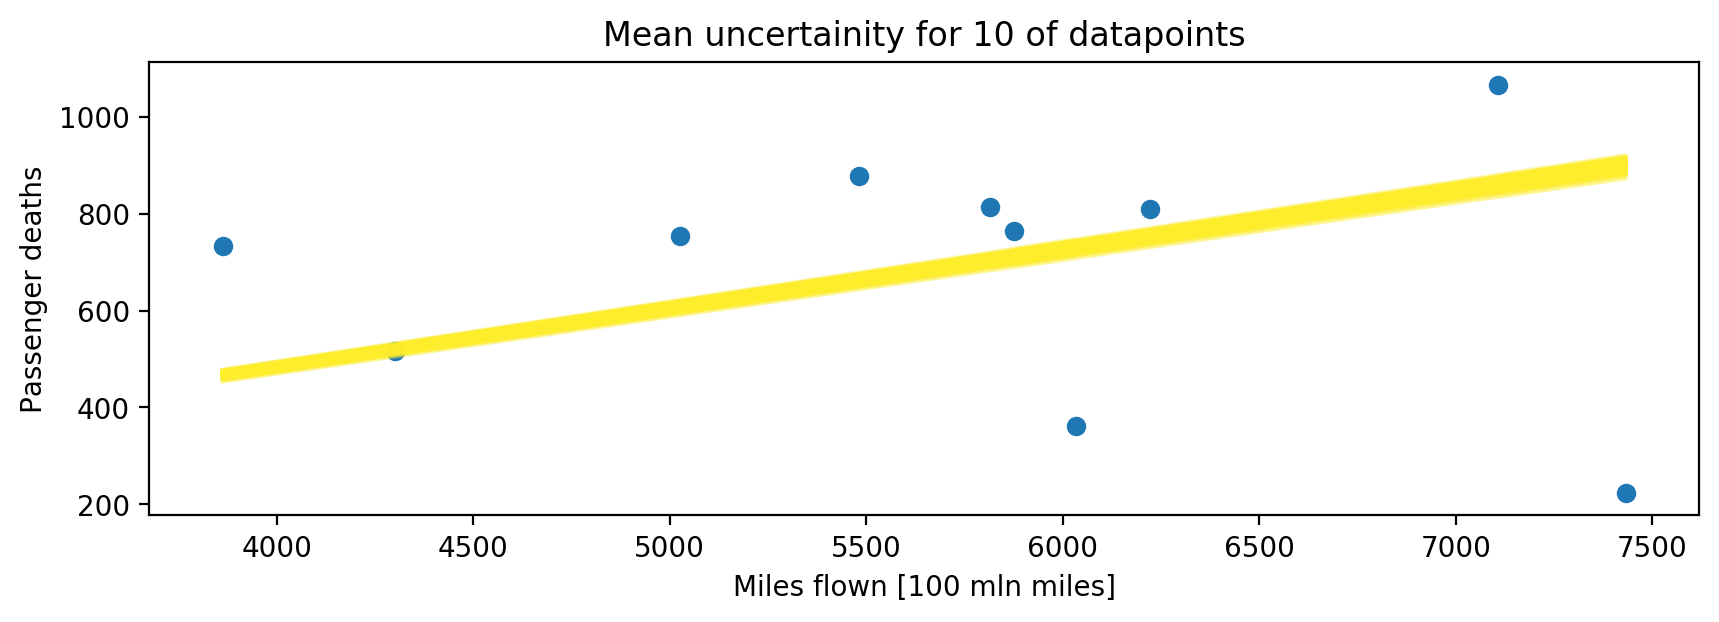

In [139]:
plt.figure(figsize = (10, 3))

for i in range(100):
    plt.plot(data['Miles flown [100 mln miles]'], (beta_model_fit2[i] * data['Miles flown [100 mln miles]']), color=mid, alpha=0.3)
    
plt.scatter(data['Miles flown [100 mln miles]'], data['Passenger deaths'])

plt.ylabel("Passenger deaths")
plt.xlabel("Miles flown [100 mln miles]")
plt.title("Mean uncertainity for "+ str(len(data)) + " of datapoints")
plt.show()

Sorting


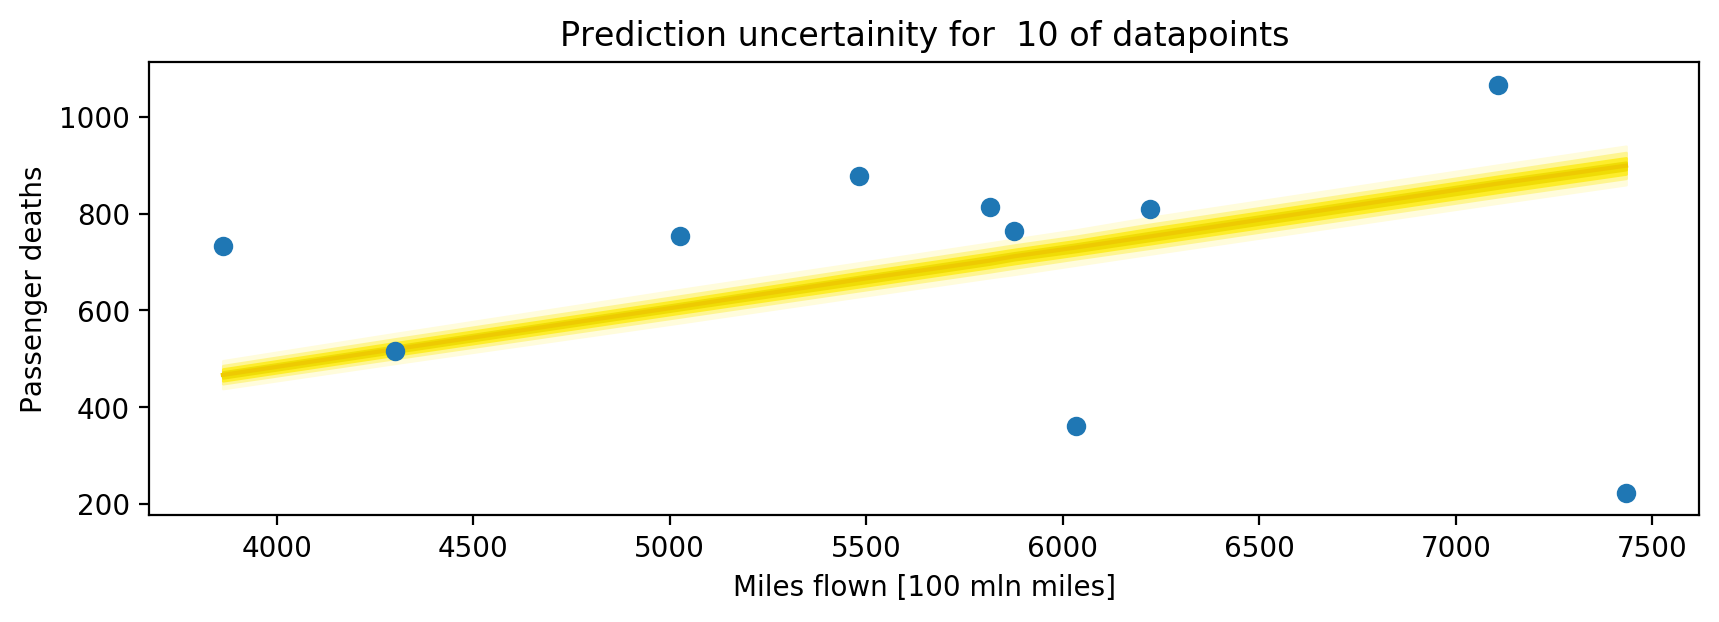

In [140]:
fig, axes = plt.subplots(1, 1, figsize=(10, 3))

axes = ribbon_plot(data['Miles flown [100 mln miles]'].values, deaths_model_fit2, axes)

plt.scatter(data['Miles flown [100 mln miles]'], data['Passenger deaths'])

plt.ylabel("Passenger deaths")
plt.xlabel("Miles flown [100 mln miles]")
plt.title("Prediction uncertainity for  "+ str(len(data)) + " of datapoints")
plt.show()